<h1><center>Data Story</center></h1> 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from datetime import timedelta

%matplotlib inline

In [2]:
train_users=pd.read_csv('data/train_users_1.csv')
countries=pd.read_csv('data/countries.csv')

#### Frist look at the distribution of destinations

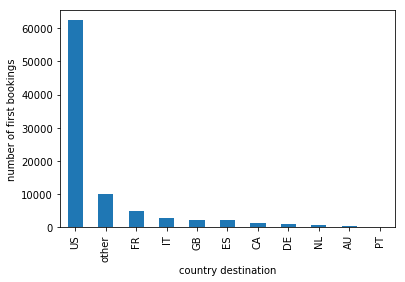

In [3]:
train_users.country_destination.value_counts().plot.bar()
plt.xlabel('country destination')
plt.ylabel('number of first bookings')

It is a skewed multiclassification 

In [4]:
US_ratio=len(train_users[train_users['country_destination']=='US'])/len(train_users)
print('US is %.1f percent in destinations.'% (US_ratio*100))

US is 70.2 percent in destinations.


#### Look at how the destinations change with time

In [5]:
train_users.date_first_booking.min(),train_users.date_first_booking.max()

('2010-01-02 00:00:00', '2015-06-29 00:00:00')

trend over year and month for domestic and international destinations

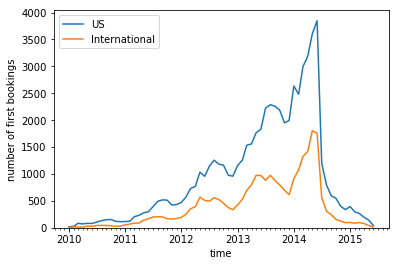

In [6]:
years = mdates.YearLocator()   
months = mdates.MonthLocator()  
yearsFmt = mdates.DateFormatter('%Y')

ax=plt.subplot(111)
trend=pd.DataFrame()
trend['US']=train_users.loc[train_users.country_destination=='US','year_month_first_booking'].value_counts().sort_index()
trend['International']=train_users.loc[train_users.country_destination!='US','year_month_first_booking'].value_counts().sort_index()
trend.index=pd.to_datetime(trend.index) # have to switch to datetime in order to use datetime in matplotlib
ax.plot(trend['US'])
ax.plot(trend['International'])
ax.legend()

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

plt.xlabel('time')
plt.ylabel('number of first bookings')
plt.ylim(bottom=0)
plt.show()

Trend:
* The trend look similar for domestic and international destinations. 
* No obvious change of proportions between the two groups with time.
* The number of bookings is increasing with time in general, but wierdly decrease in the middle of 2014, not sure if it is related to an artifact in data collection. Otherwise, it deserve focused exploration. 
* Yearly periodic pattern is seen. Yearly peak is in summer and dip is in winter. Fall and spring are transition in between. 

weekly trend

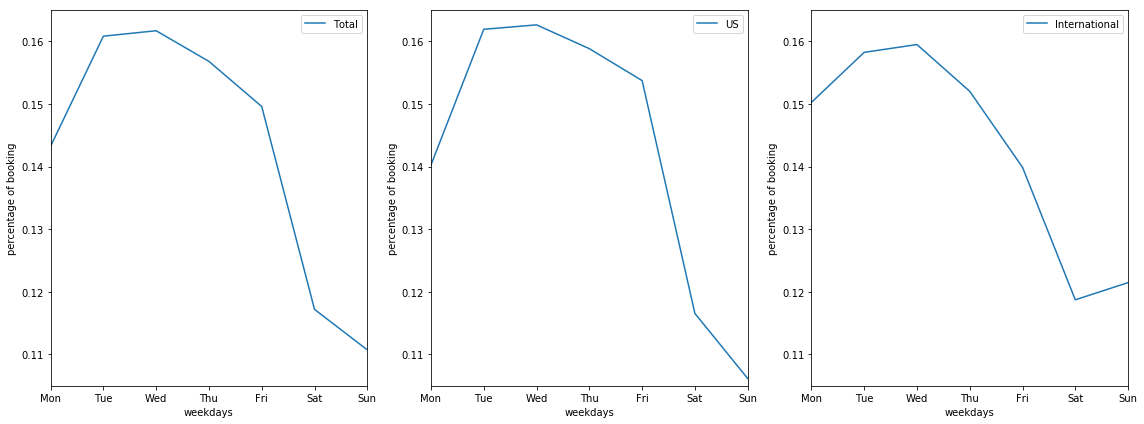

In [7]:
fig, ax = plt.subplots(1, 3, figsize=[16, 6])

(train_users['weekdays_first_booking'].value_counts()/len(train_users)).sort_index().plot(label='Total',ax=ax[0])
a=train_users.loc[train_users['country_destination']=='US','weekdays_first_booking']
(a.value_counts()/len(a)).sort_index().plot(label='US',ax=ax[1])
b=train_users.loc[train_users['country_destination']!='US','weekdays_first_booking']
(b.value_counts()/len(b)).sort_index().plot(label='International',ax=ax[2])
weekdays=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']


for i in range(len(ax)):
    ax[i].set_xticklabels(weekdays)
    ax[i].set_ylim(bottom=0.105, top=0.165)
    ax[i].set_xlabel('weekdays')
    ax[i].set_ylabel('percentage of booking')
    ax[i].legend()

ax[2].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))    
fig.tight_layout()

Weekly trend: 
* start increasing from Mon, peak at Tue and Med, worst in weekends
* different between domestic and international. international bookings when passing wedensday drops fast, while domestic booking drop is not that dramatic on Thur and Fri compared to international. Also international booking starts picking up earlier in the week from Sunday and Monday. Maybe this is because more overhead planning needs to be done for international travelling. In general, the fluctuation of booking is less for international travelling with respect to the weekly period, likely because people tend to plan for international trips with a time frame longer than a week. Recommendation based on this graph is company could advertise more on international trips in weekdays of light business, e.g. Sat to Mon.

booking when approaching holidays

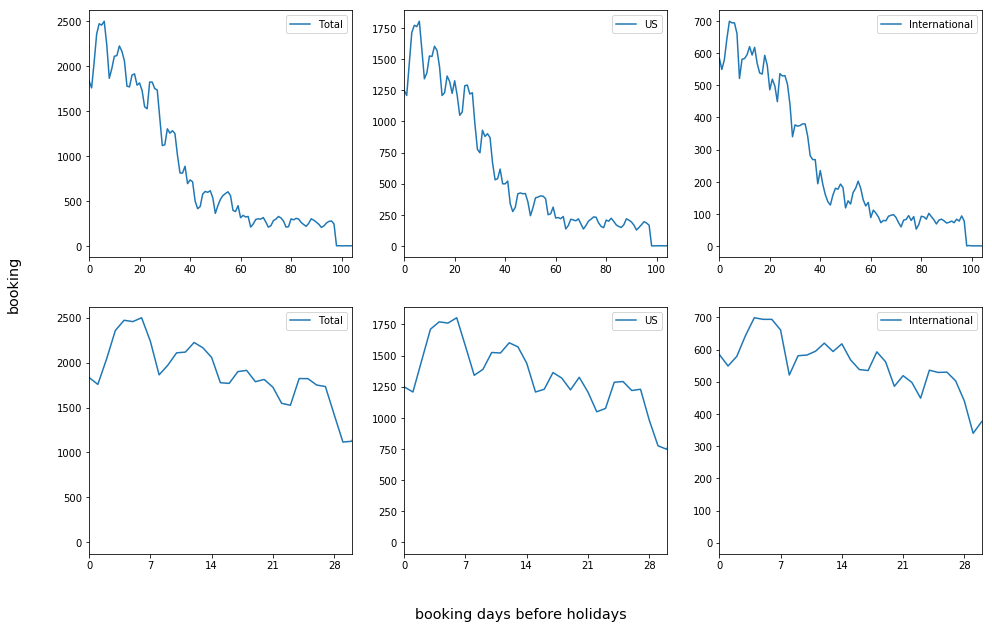

In [8]:
fig, ax = plt.subplots(2, 3, figsize=[16, 10])

for i in range(len(ax)):
    train_users['booking_days_before_holiday'].value_counts().sort_index().plot(label='Total',ax=ax[i][0])
    a=train_users.loc[train_users['country_destination']=='US','booking_days_before_holiday']
    a.value_counts().sort_index().plot(label='US',ax=ax[i][1])
    b=train_users.loc[train_users['country_destination']!='US','booking_days_before_holiday']
    b.value_counts().sort_index().plot(label='International',ax=ax[i][2])

for i in range(len(ax)):
    for j in range(len(ax[i])):
        if i==1:
            ax[i][j].set_xlim(right=30)
            ax[i][j].xaxis.set_major_locator(mpl.ticker.MultipleLocator(7))    
        ax[i][j].legend()

fig.text(0.5, 0.04, 'booking days before holidays', ha='center', va='center', size='x-large')
fig.text(0.06, 0.5, 'booking', ha='center', va='center', rotation='vertical', size='x-large')

Only a few of holiday intervals are longer than a month, so only consider 30 days before holidays. There is an obvious increase when getting closer to holidays. The weekly periodic fluctuaion is seen in this graph too because most holidays are Mondays. The peak time of booking is 5-6 days before holidays. When closer than 5-6 days, the booking drops.

#### Dependency on gender

In [9]:
gender_int=pd.DataFrame()
gender_int['US']=train_users.loc[train_users.country_destination=='US','gender'].value_counts()
gender_int['International']=train_users.loc[train_users.country_destination!='US','gender'].value_counts()
gender_int['Total']=gender_int['US']+gender_int['International']
gender_int['International booking percentage']=gender_int['International']/gender_int['Total']
gender_int

,US,International,Total,International booking percentage
FEMALE,22694,9299,31993,0.290657
MALE,19457,8264,27721,0.298113
OTHER,116,60,176,0.340909


In [10]:
perc=(gender_int.loc['FEMALE','Total']-gender_int.loc['MALE','Total'])/gender_int.loc['MALE','Total']
print('Female made {} percent more first bookings than male.'.format(
    (int)(np.round(perc*100))))

Female made 15 percent more first bookings than male.


In [11]:
perc=(gender_int.loc['MALE','International booking percentage']-gender_int.loc['FEMALE','International booking percentage'])/gender_int.loc['FEMALE','International booking percentage']
print('Male made {} percent more international bookings than female.'.format(
    (int)(np.round(perc*100))))

Male made 3 percent more international bookings than female.


#### Dependency on age

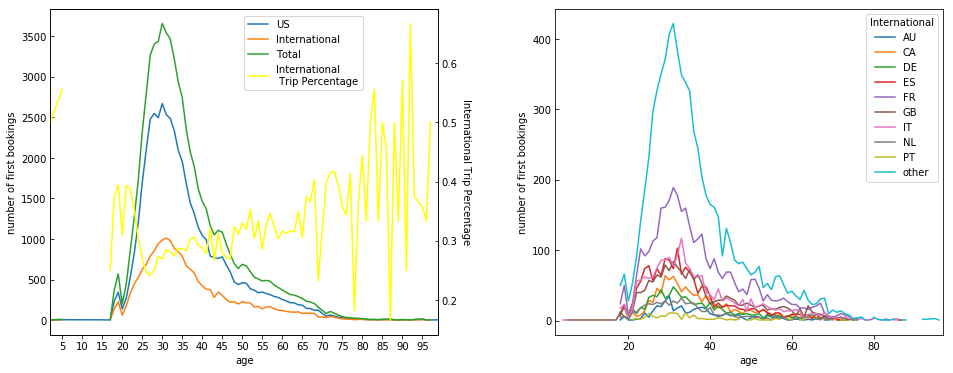

In [12]:
fig, (ax,ax_r) = plt.subplots(1, 2, figsize=[16, 6])
ax2 = ax.twinx() 


# left plot:
age_comp=pd.DataFrame()
age_comp['US']=train_users.loc[train_users.country_destination=='US','age'].value_counts()
age_comp['International']=train_users.loc[train_users.country_destination!='US','age'].value_counts()
age_comp['Total']=age_comp['US']+age_comp['International']
age_comp.sort_index(inplace=True)
age_comp.plot(ax=ax)
(age_comp['International']/age_comp['Total']).plot(ax=ax2,color='yellow',label = 'International \n Trip Percentage')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=(0.5, 0.75))

ax.set_ylabel('number of first bookings')
ax2.set_ylabel('International Trip Percentage',rotation=-90,labelpad=13)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))    

# right plot:
pd.pivot_table(train_users[train_users.country_destination!='US'], index='age', columns='country_destination', values='id',aggfunc='count').plot(ax=ax_r)
ax_r.set_ylabel('number of first bookings')
ax_r.legend(title='International')

plt.subplots_adjust(wspace=0.3)

for axi in fig.get_axes():
    axi.set_xlabel('age')
    axi.tick_params(axis='y', direction='in')

plt.show()

Booking dependency on age:
* booking peak is around early 30's, interesting dip at 20, colleage time maybe
* international traveling percentage tends to increase with age, but have a peak around early 20's
* zoom in to see any pattern dependency of countries vs. international destinations: no specific correlations between age and destinations

#### Dependency on language

In [13]:
print(train_users['language'].value_counts(),'\n',train_users['destination_language '].value_counts())

print('English speaking users are {} percent of all users.'.format(
        (int)(np.round(100*len(train_users[train_users['language']=='en'])/len(train_users)))))

print('English language destinations takes {} percent of all bookings.'.format(
        (int)(np.round(100*len(train_users[train_users['destination_language ']=='eng'])/len(train_users)))))

en       86664
zh         521
fr         399
other      324
es         275
de         270
ko         241
ru         110
it         104
Name: language, dtype: int64 
 eng    66667
fra     5023
ita     2835
spa     2249
deu     1061
nld      762
por      217
Name: destination_language , dtype: int64
English speaking users are 97 percent of all users.
English language destinations takes 75 percent of all bookings.


Non-english destinations are mostly from english speaking tourists, therefore language of the tourists is not a good estimator of destinaions.

#### Dependency on searching effort and natural properties (lattitude, distance, area) and distance for international destinations

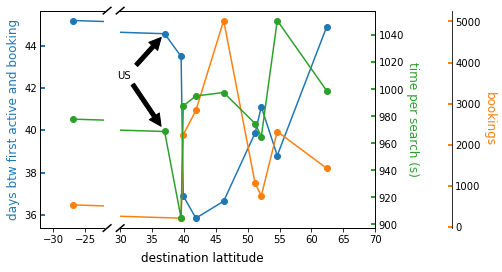

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw = {'width_ratios':[1,4]})

colors=list(plt.rcParams['axes.prop_cycle'])[:3]

ax1.plot(train_users.groupby('lat_destination')['days_btw_active_and_booking'].agg('mean').sort_index(),'-o',color=colors[0]['color'])
ax1t=ax1.twinx()
ax1t.plot(train_users.loc[train_users.country_destination!='US','lat_destination'].value_counts().sort_index(),'-o',color=colors[1]['color'])
ax1t2=ax1.twinx()
ax1t2.plot(train_users.groupby('lat_destination')['time_per_search'].agg('mean').sort_index(),'-o',color=colors[2]['color'])

ax2.plot(train_users.groupby('lat_destination')['days_btw_active_and_booking'].agg('mean').sort_index(),'-o',color=colors[0]['color'])
ax2t=ax2.twinx()
ax2t.plot(train_users.loc[train_users.country_destination!='US','lat_destination'].value_counts().sort_index(),'-o',color=colors[1]['color'])
ax2t2=ax2.twinx()
ax2t2.plot(train_users.groupby('lat_destination')['time_per_search'].agg('mean').sort_index(),'-o',color=colors[2]['color'])

ax1.set_xlim(-32,-22) 
ax2.set_xlim(30,70)


ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(axis='y', direction='in',color=colors[0]['color'],width=2,length=5)
ax2.yaxis.set_visible(False)

ax1t.spines['right'].set_visible(False)
ax1t2.spines['right'].set_visible(False)
ax2t.spines['left'].set_visible(False)
ax2t2.spines['left'].set_visible(False)
ax1t.yaxis.set_visible(False)
ax1t2.yaxis.set_visible(False)
ax2t.yaxis.tick_right()
ax2t2.yaxis.tick_right()
ax2t.tick_params(direction='in',color=colors[1]['color'],width=2,length=4)
ax2t2.tick_params(direction='in',color=colors[2]['color'],width=2,length=4)

# Make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace=0.1)
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+7*d),(-d,+d), **kwargs) # top-left diagonal
ax1.plot((1-d,1+7*d),(1-d,1+d), **kwargs) # bottom-left diagonal

kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
ax2.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
ax2.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal


# Move the last y-axis spine over to the right by 20% of the width of the axes
ax2t.spines['right'].set_position(('axes', 1.3))


# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
ax2t.set_frame_on(True)
ax2t.patch.set_visible(False)

ax1.set_ylabel('days btw first active and booking',color=colors[0]['color'],size='large')
ax2t.set_ylabel('bookings',rotation=-90,color=colors[1]['color'],labelpad=15,size='large')
ax2t2.set_ylabel('time per search (s)',rotation=-90,color=colors[2]['color'],labelpad=15,size='large')

filter=countries.loc[countries['country_destination']=='US','lat_destination']
dUS=train_users.groupby('lat_destination')['days_btw_active_and_booking'].agg('mean').loc[filter]
ax2.annotate('US',
            xy=(float(filter),float(dUS.values)), 
            xytext=(float(filter)*0.8,float(dUS.values)*0.95), 
            arrowprops=dict(color='black', shrink=0.1),
            horizontalalignment='left',
            verticalalignment='bottom',
            )
tUS=train_users.groupby('lat_destination')['time_per_search'].agg('mean').loc[filter]
ax2t2.annotate('',
            xy=(float(filter),float(tUS.values)), 
            xytext=(float(filter)*0.85,float(tUS.values)*1.04),
            arrowprops=dict(color='black', shrink=0.1),
            horizontalalignment='left',
            verticalalignment='bottom',
            )

fig.text(0.5, 0.02, 'destination lattitude', ha='center', va='center',size='large')

days_btw_active_and_booking is opposite trend with bookings, while time per search is the same trend with bookings. 
* More days of hesitation between active and booking for a destination, the destination is less likely to be booked.
* More time spent on searching, the destination is more likely to be booked.
* Non-determinative on whether lattitude of the destination is an effect factor of the booking or not, too few data points and too noisy.

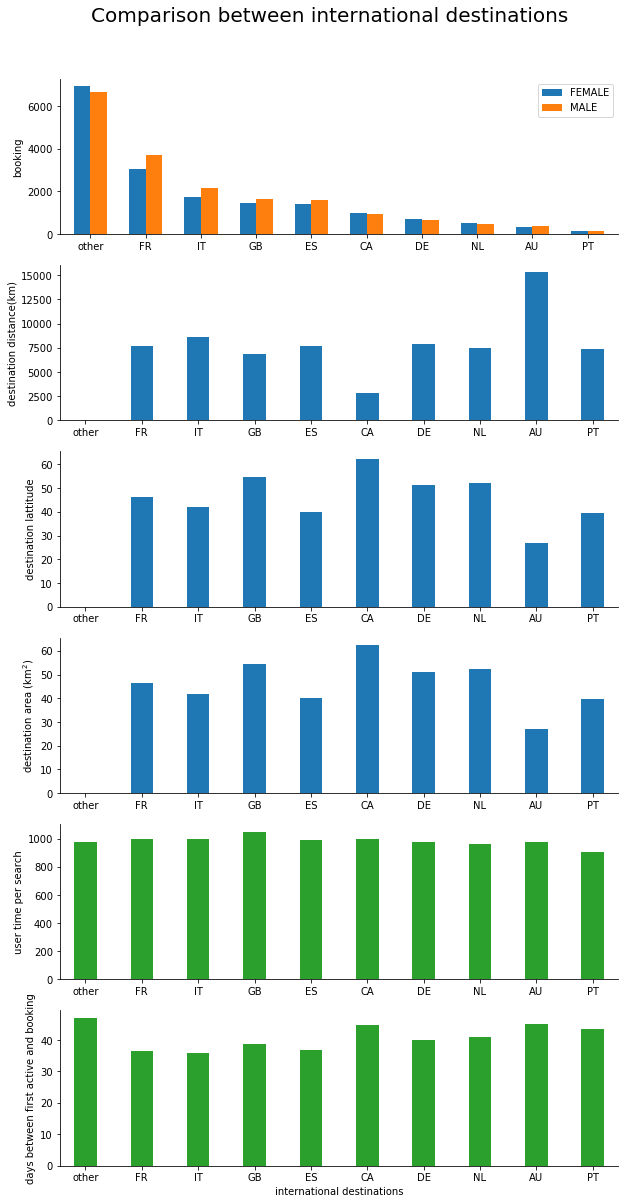

In [15]:
fig, ax = plt.subplots(6,1,figsize=[10, 20])
booking=pd.DataFrame()
booking['FEMALE']=train_users[(train_users['country_destination']!='US')&(train_users['gender']!='FEMALE')].country_destination.value_counts()
booking['MALE']=train_users[(train_users['country_destination']!='US')&(train_users['gender']!='MALE')].country_destination.value_counts()
booking.plot(kind='bar',ax=ax[0],rot=0,width=0.6)

distance=pd.Series(data=countries.distance_km)
distance.index=countries.country_destination
distance=distance[booking.index.values.tolist()]
distance.plot(kind='bar',ax=ax[1],rot=0,width=0.4)

lat_destination=pd.Series(data=np.abs(countries.lat_destination))
lat_destination.index=countries.country_destination
lat_destination=lat_destination[booking.index.values.tolist()]
lat_destination.plot(kind='bar',ax=ax[2],rot=0,width=0.4)

destination_km2=pd.Series(data=countries.destination_km2)
destination_km2.index=countries.country_destination
destination_km2=lat_destination[booking.index.values.tolist()]
destination_km2.plot(kind='bar',ax=ax[3],rot=0,width=0.4)

time_per_search=train_users[train_users['country_destination']!='US'].groupby('country_destination').time_per_search.agg('mean')
time_per_search=time_per_search[booking.index.values.tolist()]
time_per_search.plot(kind='bar',ax=ax[4],rot=0,width=0.4,color=list(plt.rcParams['axes.prop_cycle'])[2]['color'])

days_btw_active_and_booking=train_users[train_users['country_destination']!='US'].groupby('country_destination').days_btw_active_and_booking.agg('mean')
days_btw_active_and_booking=days_btw_active_and_booking[booking.index.values.tolist()]
days_btw_active_and_booking.plot(kind='bar',ax=ax[5],rot=0,width=0.4,color=list(plt.rcParams['axes.prop_cycle'])[2]['color'])

ylabels=['booking','destination distance(km)','destination lattitude',r'destination area ($\mathrm{km}^2$)','user time per search','days between first active and booking']
for axi, ylabel in zip(ax,ylabels):
    axi.set_ylabel(ylabel)
    axi.xaxis.label.set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

ax[-1].set_xlabel('international destinations')
ax[-1].xaxis.label.set_visible(True)
fig.suptitle('Comparison between international destinations',x=0.5,y=0.93,fontsize=20)

* While males have higher booking for FR, IT, GB, ES, females have higher booking for less populor countries especially other
* Just from graph, none of lattitude, distance, and area has strong effect on destination predictions. 
* Average time per search for those destinations is around one month 

## Inferential Statistics

#### Are the male and female tourists have any difference in choosing destinations 

use chi square two sample test. 

null hypothesis: Female and male groups have no difference in choosing destinations 

In [16]:
test1=pd.DataFrame()
test1['female']=train_users.loc[train_users.gender=='FEMALE','country_destination'].value_counts()
test1['male']=train_users.loc[train_users.gender=='MALE','country_destination'].value_counts()
chi2, p, dof, expected=stats.chi2_contingency(test1)
p

1.6903821526166661e-40

#### US and international tourists age distribution same? 

null hypothesis:  the age means of US and international tourist groups are the same

Approach 1: deal with age as continous variable, use two sample t test

In [17]:
US_age=train_users.loc[train_users.country_destination=='US','age']
IN_age=train_users.loc[train_users.country_destination!='US','age']
t, p = stats.ttest_ind(US_age.dropna(),IN_age.dropna(),equal_var=False)
p

3.022441829939547e-12

Approach 2: deal with age as catagorical variable, use chi test two sample test

In [18]:
age=pd.DataFrame() # bin ages to 1 year
age['US']=train_users.loc[train_users.country_destination=='US','age'].value_counts().sort_index()
age['IN']=train_users.loc[train_users.country_destination!='US','age'].value_counts().sort_index()
age=age[age>=5]
age.dropna(inplace=True)
chi2_1, p_1, dof_1, expected_1=stats.chi2_contingency([age['US'],age['IN']])

age_bucket=pd.DataFrame() # bin ages to 1 year
age_bucket['US']=train_users.loc[train_users.country_destination=='US'].groupby(train_users.age//5).id.agg('count').sort_index()
age_bucket['IN']=train_users.loc[train_users.country_destination!='US'].groupby(train_users.age//5).id.agg('count').sort_index()
age_bucket=age_bucket[age_bucket>=5]
age_bucket.dropna(inplace=True)
chi2_2, p_2, dof_2, expected_2=stats.chi2_contingency(age_bucket)
p_1,p_2

(1.5869872271779905e-45, 1.251975672372474e-49)

All p values in above tests are very small, for the reason that the sample size is too large. 

Future study: use other statistical methods such as confidence intervals.

#### Explore age_gender_bkts data

My understanding of this data is it is the statistics of all users for all trips (not just first booking) in year 2015.

In [19]:
age_gender_bkts=pd.read_csv('data/age_gender_bkts.csv')
age_gender_bkts.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [20]:
train_users['date_first_booking']=pd.to_datetime(train_users['date_first_booking'])
train_users.date_first_booking.max()

Timestamp('2015-06-29 00:00:00')

In [21]:
# To make the comparison in time, I use 2015 first half year combined with 2014 last half year data to compare with age_gender_bkts 2015 year data
first_booking=train_users[train_users.date_first_booking>(train_users.date_first_booking.max()-pd.DateOffset(years=1))]
first_booking.date_first_booking.min()

Timestamp('2014-06-30 00:00:00')

In [22]:
first_booking=first_booking.groupby([first_booking.age//5,'gender','country_destination']).id.agg('count')
first_booking=first_booking.reset_index()
first_booking=first_booking.rename(columns={'age':'age_bucket', 'id':'first_booking_count'})

# before merging two tables, unifying item names
first_booking['age_bucket']=first_booking['age_bucket'].apply(lambda x:str(int(5*x))+'-'+str(int(5*x)+4))
first_booking['gender']=first_booking['gender'].str.lower()

first_booking=first_booking.merge(age_gender_bkts.drop('year',1), how='left', left_on=['age_bucket','gender','country_destination'],
                      right_on=['age_bucket','gender','country_destination'])
first_booking=first_booking[first_booking['first_booking_count']>=5].dropna()
total_first_bookings=np.sum(first_booking['first_booking_count'])
total_population=np.sum(first_booking['population_in_thousands'])
first_booking['expected']=total_first_bookings*first_booking['population_in_thousands']/total_population
first_booking.head()

,age_bucket,gender,country_destination,first_booking_count,population_in_thousands,expected
2,15-19,female,US,25,10570.0,142.730730
8,15-19,male,US,17,11025.0,148.874768
11,20-24,female,DE,7,2161.0,29.180805
12,20-24,female,ES,11,1106.0,14.934739
13,20-24,female,FR,18,1947.0,26.291082


Use chi square to test if first booking represent the distribution of populations of users in age_gender_bkts data. The catogories chosen here is defined by the combination of age bucket, gender and destination. 

Null Hypothesis: the first booking distribution represent the population (from age_gender_bkts data) distribution

In [23]:
stats.chisquare(f_obs= first_booking['first_booking_count'], f_exp= first_booking['expected'])

Power_divergenceResult(statistic=5498.1108508089274, pvalue=0.0)

Null hypothesis is rejected, first booking does not represent the distribution of populations of users in age_bucket data.

#### Tourists not speaking English are they prefer to visiting destinations matching their languages?

Using one sample chi square test:

Alternative hypothesis: french speaking tourists are more likely to go to french speaking countries than general tourist

Null hypothesis: the probability of a certain speaking tourists going to countries with that language speaking are the same as general tourists


In [24]:
def get_p_languages(lang):
    des_fr=pd.DataFrame(index=['destinations of matching language','other destinations'],columns=['Native Speakers','exepected from population'])
    filter1=train_users['language']==lang[1]
    filter2=train_users['destination_language ']==lang[2]
    filter3=train_users['destination_language '].notnull()
    des_fr.loc['destinations of matching language','Native Speakers']=len(train_users[filter1&filter2])
    des_fr.loc['other destinations','Native Speakers']=len(train_users[filter1&(~filter2)&filter3])
    total=des_fr['Native Speakers'].sum()
    tot_p=len(train_users[filter3])
    des_fr.loc['destinations of matching language','exepected from population']=total*len(train_users[filter2])/tot_p
    des_fr.loc['other destinations','exepected from population']=total*len(train_users[(~filter2)&filter3])/tot_p
    p=stats.chisquare(f_obs= des_fr['Native Speakers'], f_exp= des_fr['exepected from population']).pvalue
    print('The probability that {} speakers going to {}-speaking destinations than general population is {}significantly different than general population. p value is {}.'.format(
        lang[0],lang[0],'' if p<0.05 else 'not ',p))

for i in zip(['French','Spanish','Italian','German'],['fr','es','it','de'],['fra','spa','ita','deu']):    
    get_p_languages(i)

The probability that French speakers going to French-speaking destinations than general population is significantly different than general population. p value is 5.235050337875814e-21.
The probability that Spanish speakers going to Spanish-speaking destinations than general population is significantly different than general population. p value is 7.988248099481366e-08.
The probability that Italian speakers going to Italian-speaking destinations than general population is significantly different than general population. p value is 2.7374695454209217e-17.
The probability that German speakers going to German-speaking destinations than general population is significantly different than general population. p value is 1.963817512277236e-29.
